# Exercise

Let's look at the redshift distributions of the quasars in the Sloan Digital Sky Survey. In phase 1, SDSS has released photometry data 357 million sources and 1.6 million spectra. In phase 2, SDSS observed the same patch of the sky many times. 

Download the SDSS quasars data.

In [1]:
from astroML.datasets import fetch_dr7_quasar

# Fetch the quasar data
data = fetch_dr7_quasar()

# select the first 10.000 points
data = data[:10000]

z = data['redshift']

1. Upsample this distribution in two ways, using both rejection sampling and inverse transform.
2. Check, at least visually, that the two cloned distribitions are indeed similar to the observed one (for a quantitative check, come back to this point in a few lectures)

(Hint: `scipy.stats` is your best friend)

3. Think about the cosmology of quasars. How do you think they are distributed? Overplot the theorethical distribution to the measured SDSS data 

(Hint: `astropy.cosmology` is another close friend). The best-fit cosmological model from the Plack data is:

In [2]:
import astropy
astropy.cosmology.Planck15

FlatLambdaCDM(name="Planck15", H0=67.74 km / (Mpc s), Om0=0.3075, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from astroML.density_estimation import EmpiricalDistribution
import random

First of all, I make an histogram to visualize the distribution of the redshift.

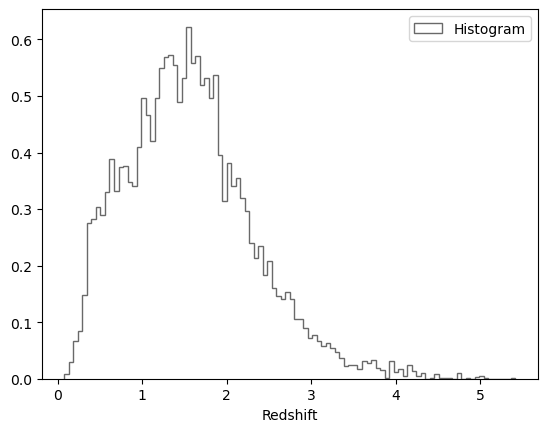

In [4]:
Nbins = int((len(z))**0.5)
histo = plt.hist(z, bins=Nbins, edgecolor='dimgrey', histtype='step', density=True, label='Histogram')
plt.legend()
plt.xlabel('Redshift')
plt.show()

Because I do not have the probability distribution function of this set of data, I want to compute the height and the width of each bin.

In [5]:
histo

(array([0.00750005, 0.03000019, 0.06750042, 0.08437555, 0.14812589,
        0.2756268 , 0.28312669, 0.30375182, 0.28875189, 0.33000216,
        0.38812754, 0.3318768 , 0.37500245, 0.37687747, 0.34875228,
        0.34125223, 0.41062723, 0.49687881, 0.46687753, 0.42000228,
        0.49687881, 0.54937798, 0.56812808, 0.57187938, 0.55500301,
        0.48937875, 0.53250289, 0.62250338, 0.55875428, 0.57000309,
        0.51937898, 0.53250289, 0.4968777 , 0.53625411, 0.39562715,
        0.31500241, 0.38062706, 0.34125185, 0.35437692, 0.31875173,
        0.29625293, 0.2400013 , 0.21375116, 0.23437627, 0.183751  ,
        0.20812706, 0.16125087, 0.14625079, 0.14062576, 0.15375083,
        0.14062639, 0.10500057, 0.10500057, 0.09000049, 0.07125039,
        0.07687576, 0.06750037, 0.05812532, 0.06375035, 0.05437529,
        0.04687546, 0.0375002 , 0.02250012, 0.02437513, 0.02437513,
        0.01687509, 0.03187532, 0.02812515, 0.03375018, 0.0187501 ,
        0.01500008, 0.00187502, 0.03187517, 0.01

When I make $print(histo)$ the first array shows the height of the bin and the second one the value of the x measured at the left extreme of the same bin. Therefore, I define two arrays containing respectively the heights and the values of the left extreme for each bin.

Then I define the width of each bin to be equal to the fixed value $(x_{Max}-x_{Min})/N_{bins}$.

In [6]:
height = []
valueSx = []

height = histo[0]
valueSx = histo[1]

xMin = min(valueSx)
xMax = max(valueSx)
width = (xMax-xMin)/Nbins

print(width)

0.05333299830555916


#### Rejection sampling:

I generate two arrays x and y containing respectively the samples drawn from the uniform distribution between $x_{Min}$ and $x_{Max}$ (this uniform distribution is my $q(x)$) and from the uniform distribution between $0$ and $heightMax$, which is the maximum of the histogram (these are the samples of the y-axes).

In the cycle while I am creating an array of heights ($Height$) whose length is $N$, because $height$ is long $N_{bins}$ and I want an array whose length is equal to the ones of x and y.

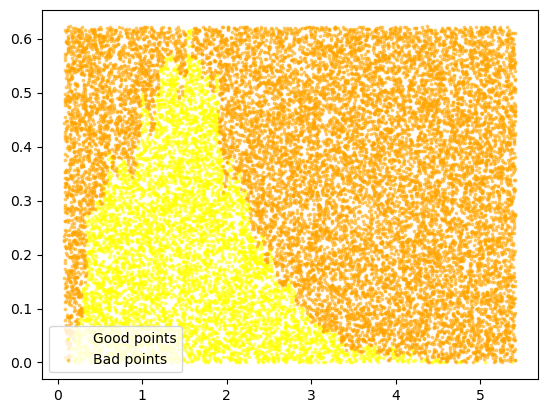

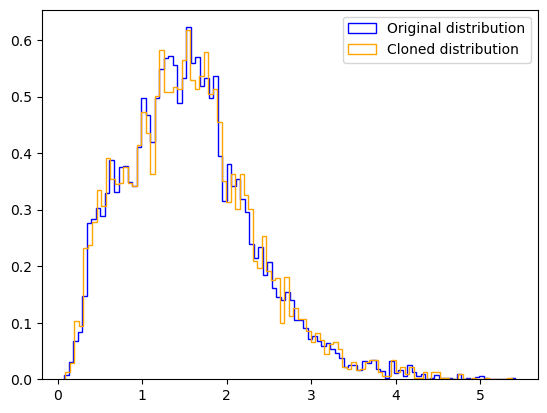

In [7]:
heightMax = max(height)
N = 20000  # number of points to be generated

x = np.random.uniform(xMin, xMax, N)
y = np.random.uniform(0, heightMax, N)

Height = []  # array in which I write N values from the height

# I want a random uniform for a total x number per bin = N*(height of the corresponding bin)
i = 0
while i<len(height):
    k = 0
    while k<(N/Nbins):  # N = total number of points; N/Nbins = number of points per bin
        Height.append(height[i])  # I append N/Nbins times the value of height[i] for each i
        k = k+1
    i = i+1

# I have to compute the corresponding height for each value of x
valuesX = x.copy()
valuesX.sort()

plt.scatter(valuesX[y<Height], y[y<Height], c='yellow', s=3, alpha=0.5, label='Good points')
plt.scatter(valuesX[y>Height], y[y>Height], c='orange', s=3, alpha=0.5, label='Bad points')
plt.legend()
plt.show()

goodpoints = valuesX[y<Height]

plt.hist(z, bins=Nbins, histtype='step', density=True, color='blue', label='Original distribution')
plt.hist(goodpoints, bins=Nbins, density=True, histtype='step', color='orange', label='Cloned distribution')
plt.legend()
plt.show()

#### Inverse transform:

Because I have a histogram and not the probability distribution function, the cumulative distribution function can be computed for a given bin as the cumulative sum of the heights of each bin before the one in consideration.

In the function $clone_distribution$ I clone the values from the histogram by using inverse transform sampling. $sumHeights$ is the value of the last element of the array $cdf$, and it corresponds to the cumulative sum of all the heights of the histogram. Because it is a probability, $cdf$ must be normalized by dividing by the cumulative sum of all the heights: I call this normalized cdf $CDF$. Then, I generate the y random variables between $0$ and $1$ and I insert them in the quantile function to obtain the cloned values of x.

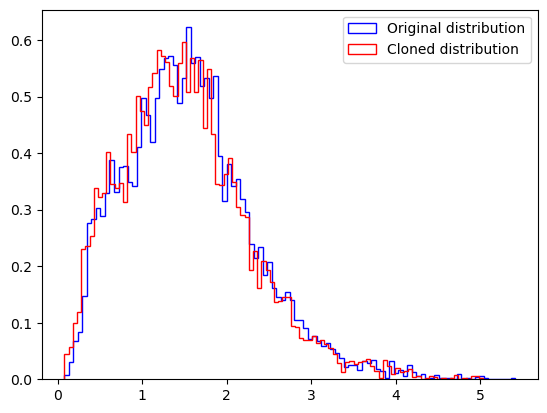

In [8]:
def clone_distribution(yy, xx, n):
    cdf = np.cumsum(yy)  # cdf = cumulative sum of the heights of the histogram
    sumHeights = cdf[-1]
    CDF = cdf/sumHeights

    y_random = np.random.uniform(0, 1, n)
    Xcloned = np.interp(y_random, CDF, xx[:-1])  # invert the cdf
    # with xx[:-1] I exclude the right edge of the last bin
    
    return Xcloned

x_cloned = clone_distribution(height, valueSx, len(z))

plt.hist(z, bins=Nbins, density=True, histtype='step', color='blue', label='Original distribution')
plt.hist(x_cloned, bins=Nbins, density=True, histtype='step', color='red', label='Cloned distribution')
plt.legend()

plt.show()

The following plot compares the three different distributions.

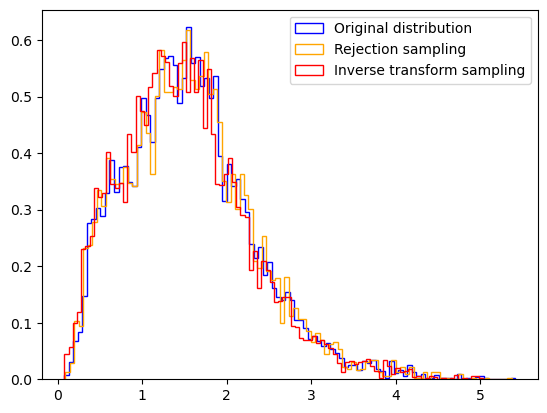

In [9]:
plt.hist(z, bins=Nbins, histtype='step', density=True, color='blue', label='Original distribution')
plt.hist(goodpoints, bins=Nbins, density=True, histtype='step', color='orange', label='Rejection sampling')
plt.hist(x_cloned, bins=Nbins, histtype='step', density=True, color='red', label='Inverse transform sampling')
plt.legend()
plt.show()

To study the cosmology of quasars, I firstly compute the differential comoving volume for an array of redshifts ($redshift$) defined in the range of the redshift from the SDSS data. I consider a normalization constant defined by hand to make the two distributions comparable and I normalize the differential volume by dividing by $Sum$ (it is a probability distribution).

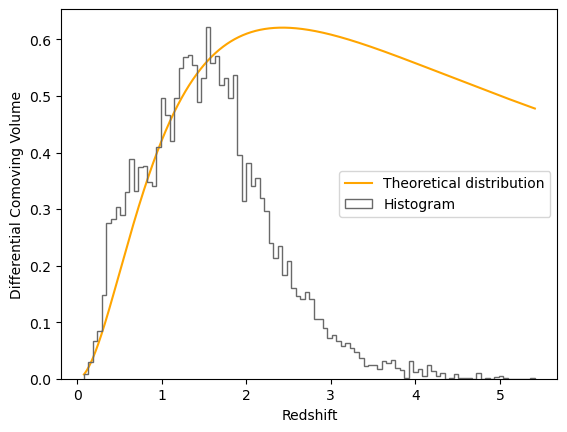

In [10]:
redshift = np.linspace(z.min(), z.max(), N)
diff_volume = astropy.cosmology.Planck15.differential_comoving_volume(redshift)
Sum = np.sum(diff_volume)
nor = 1.*10**4  # normalization constant

plt.plot(redshift, nor*diff_volume/Sum, color='orange', label='Theoretical distribution')
histo = plt.hist(z, bins=Nbins, edgecolor='dimgrey', histtype='step', density=True, label='Histogram')
plt.xlabel('Redshift')
plt.ylabel('Differential Comoving Volume')
plt.legend()
plt.show()

Observations:

1. the sampling distribution seems to follow the theoretican prediction for small values of the redshift, although the behavior does not match perfectly.
2. as the redshift increases (from roughly $z=1.8$), the observations become increasingly at odds with the theoretical expectation.